# Import Modules

In [2]:
# import pytorch
import torch
from torch import nn

# import torchvision
import torchvision
import torchvision.models as models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Import matplotlib for visualization
import matplotlib.pyplot as plt

import os
from PIL import Image
import shutil

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [3]:
!pip install torchmetrics -U mlxtend

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [ ]:
class CovidSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.samples = []
        self.transform = transform
        self.mask_transform = mask_transform
        
        class_names = os.listdir(root_dir)
        self.class_names = sorted(class_names)

        for class_name in self.class_names:
            img_dir = os.path.join(root_dir, class_name, 'images')
            mask_dir = os.path.join(root_dir, class_name, 'masks')

            if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
                continue

            for img_name in os.listdir(img_dir):
                img_path = os.path.join(img_dir, img_name)
                mask_path = os.path.join(mask_dir, img_name)  # same filename expected
                if os.path.exists(mask_path):  # ensure both exist
                    self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale for binary/class masks

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [ ]:
def flatten_dataset(original_root, target_root):
    if not os.path.exists(target_root):
        os.makedirs(target_root)

    class_names = os.listdir(original_root)
    for class_name in class_names:
        class_path = os.path.join(original_root, class_name)
        image_folder = os.path.join(class_path, "images")

        if not os.path.exists(image_folder):
            continue

        target_class_folder = os.path.join(target_root, class_name)
        os.makedirs(target_class_folder, exist_ok=True)

        for img_name in os.listdir(image_folder):
            src_path = os.path.join(image_folder, img_name)
            dst_path = os.path.join(target_class_folder, img_name)
            shutil.copy(src_path, dst_path)

    print("Dataset has been flattened successfully.")

In [ ]:
original_dir = "./COVID-19_Radiography_Dataset"
new_dir = "./flattened_dataset"
flatten_dataset(original_dir, new_dir)

In [4]:
!pip install split-folders

In [8]:
import splitfolders

# Define the input and output directories
input_folder = './flattened_dataset'  # Replace with your dataset path
output_folder = './data'  # Replace with your desired output path

# Split the dataset into 70% train, 15% val, and 15% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 21165 files [00:02, 7481.47 files/s]


# Data Transforms 

In [6]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.Lambda(lambda image: image.convert("RGB")),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.Lambda(lambda image: image.convert("RGB")),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])]),
                    "test":transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)])}

# Make Datasets and DataLoaders

In [7]:
# Paths to the split datasets
train_dir = '/content/data/train'
val_dir = '/content/data/val'
test_dir = '/content/data/test'

# Create datasets
train_dataset = ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = ImageFolder(test_dir, transform=data_transforms['test'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

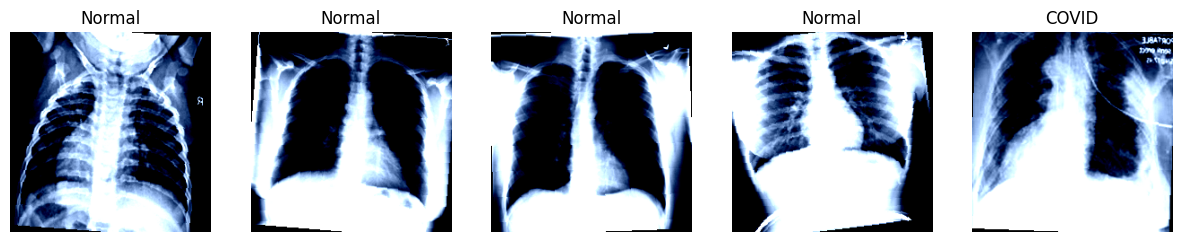

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Define class names (replace with your actual class names)
class_names = train_dataset.classes  # Automatically obtained from ImageFolder

# Function to display a grid of images
def imshow(imgs, labels):
    imgs = imgs.numpy()
    fig, axes = plt.subplots(1, len(imgs), figsize=(15, 5))
    for idx, (img, label) in enumerate(zip(imgs, labels)):
        img = np.transpose(img, (1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
        axes[idx].imshow(img)
        axes[idx].set_title(class_names[label])
        axes[idx].axis('off')
    plt.show()

# Display the first 5 images in the batch
imshow(images[:5], labels[:5])

# Define functions

In [9]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [10]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device= None):
  """Print difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [14]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  """Performs a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0, 0

  # put  model into training mode
  model.train()

  # add loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

    # put data on target device
    X, y = X.to(device), y.to(device) # Move X and y to the same device as the model

    # 1. forward pass
    y_pred = model(X)

    # 2. calculate loss and accuracy(per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

    # 3. Optimazer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. optimzer step
    optimizer.step()

  # Devide total train loss and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | train acc: {train_acc:.2f}%")

In [15]:
def val_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""
  test_loss, test_acc = 0 ,0

  # put the model in eval mode
  model.eval()

  # trun on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # send the data on the target device
      X, y = X.to(device), y.to(device)

      # 1. forward pass
      test_pred = model(X)

      # 2. calculate loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred= test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | test acc: {test_acc:.2f}%")

In [16]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
  """Returns a dictionary Containing the results of model predicting on dataloader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      X,y = X.to(device), y.to(device)

      # make predictions
      y_pred = model(X)

      # Accumulate the loss and  acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

    # Scale loss and acc to find the avarage loss / acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [17]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the sample (add a batch dimension and pass to target)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forward pass (model output raw logits)
      pred_logits = model(sample)

      # get prediciton probability (logits -> prediction probability)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      # get pred_prob off the gpu
      pred_probs.append(pred_prob.cpu())

  # stack the pred_probs to turn list into tensor
  return torch.stack(pred_probs)

# Load Pretrained Model

In [51]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pretrained VGG19
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
vgg.classifier[6] = nn.Linear(4096, 4)

# Load pretrained ResNet50
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(resnet.fc.in_features, 4)

# Move models to device
vgg = vgg.to(device)
resnet = resnet.to(device)

# Create Ensemble Class

In [52]:
import torch.nn.functional as F

class StackingEnsemble(nn.Module):
    def __init__(self, model1, model2, num_classes):
        super(StackingEnsemble, self).__init__()
        self.model1 = model1
        self.model2 = model2
        # The stacking layer takes 2 * num_classes as input
        self.stacking_layer = nn.Linear(2 * num_classes, num_classes)

    def forward(self, x):
        # Forward pass through both models
        out1 = self.model1(x)  # logits
        out2 = self.model2(x)  # logits

        # Convert logits to probabilities
        probs1 = F.softmax(out1, dim=1)
        probs2 = F.softmax(out2, dim=1)

        # Concatenate probabilities
        combined = torch.cat((probs1, probs2), dim=1)

        # Pass through the meta-classifier
        output = self.stacking_layer(combined)
        return output

# Instantiate the stacking ensemble
model = StackingEnsemble(vgg, resnet, 4)
model = model.to(device)

# Define Loss function and Optimizer

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Training Loop

In [54]:
# import tqdm for proggres bar
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# measure time
from timeit import default_timer as timer
train_time_start_model = timer()

# train and test model
epochs = 25
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model,
             data_loader=train_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  val_step(model=model,
            data_loader=val_loader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model = timer()
total_train_time_model = print_train_time(start= train_time_start_model, end= train_time_end_model,device= device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.20847 | train acc: 52.38%
Test loss: 1.15624 | test acc: 62.19%
Epoch: 1
------
Train loss: 1.11316 | train acc: 62.39%
Test loss: 1.07761 | test acc: 61.75%
Epoch: 2
------
Train loss: 1.03756 | train acc: 63.01%
Test loss: 1.01731 | test acc: 61.78%
Epoch: 3
------
Train loss: 0.97123 | train acc: 70.33%
Test loss: 0.95007 | test acc: 84.44%
Epoch: 4
------
Train loss: 0.91273 | train acc: 86.22%
Test loss: 0.90523 | test acc: 84.69%
Epoch: 5
------
Train loss: 0.86198 | train acc: 86.82%
Test loss: 0.84980 | test acc: 85.75%
Epoch: 6
------
Train loss: 0.81957 | train acc: 86.78%
Test loss: 0.80125 | test acc: 86.28%
Epoch: 7
------
Train loss: 0.77452 | train acc: 87.66%
Test loss: 0.75828 | test acc: 87.59%
Epoch: 8
------
Train loss: 0.73684 | train acc: 87.90%
Test loss: 0.73018 | test acc: 86.72%
Epoch: 9
------
Train loss: 0.70477 | train acc: 87.81%
Test loss: 0.70483 | test acc: 87.88%
Epoch: 10
------
Train loss: 0.66836 | train acc: 88.50%
Tes

In [55]:
# get model results dictionary
model_results = eval_model(model=model,
                             data_loader=test_loader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_results

  0%|          | 0/100 [00:00<?, ?it/s]

{'model_name': 'StackingEnsemble',
 'model_loss': 0.36030757427215576,
 'model_acc': 95.0340909090909}

In [56]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# view the first sample shape
test_samples[0].shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'Normal')

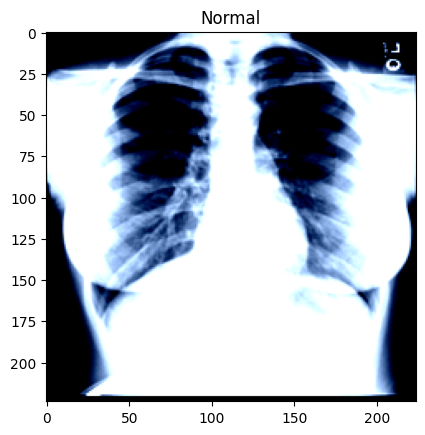

In [57]:
plt.imshow(test_samples[0].permute(1, 2, 0).numpy(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [58]:
# make predictions
pred_probs = make_predictions(model,data=test_samples)

# view first two prediction probs
pred_probs[:2]

tensor([[0.0532, 0.0663, 0.8492, 0.0313],
        [0.6930, 0.1360, 0.1349, 0.0361]])

In [59]:
# convert prediction probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 0, 0, 3, 1, 1, 1, 1, 3])

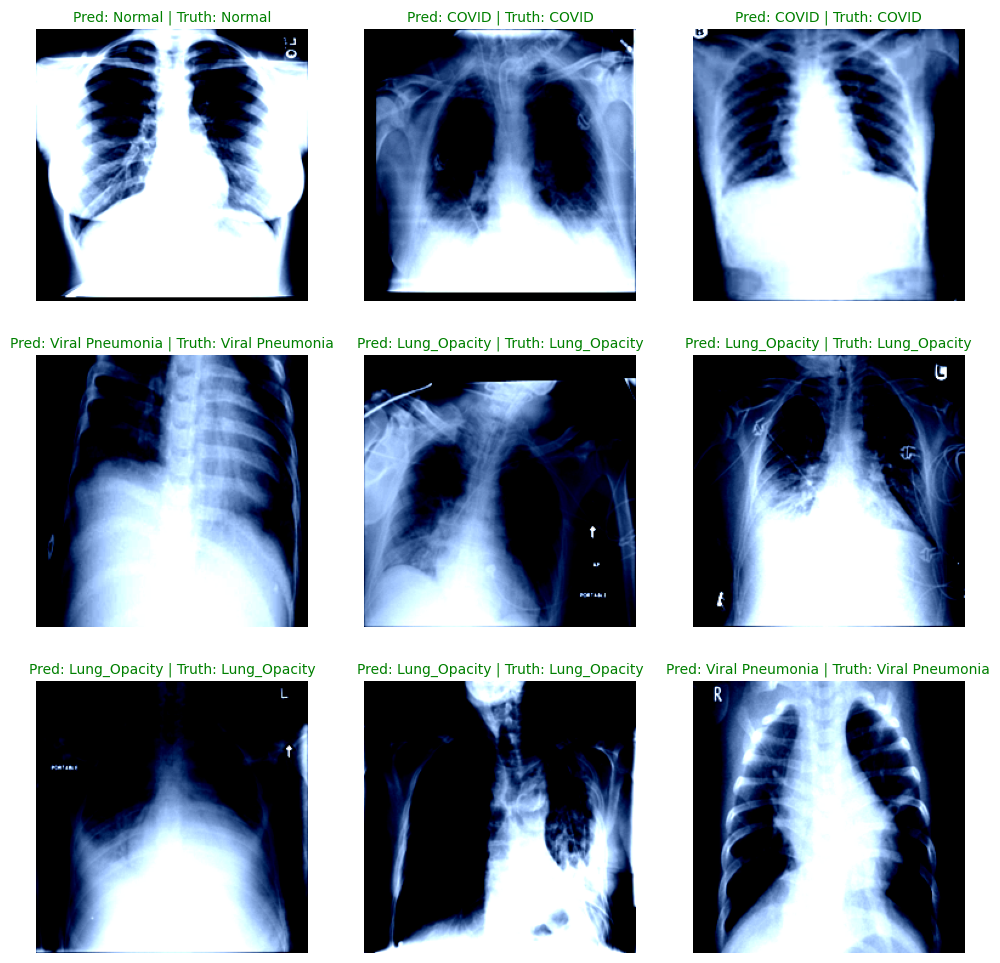

In [63]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1, 2, 0).numpy(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# Confusion Matrix

In [60]:
# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making Predictions..."):
    # send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # do the forward pass
    y_logit = model(X)
    # Turn predicitons from logits -> predicitons probs -> predicitions label
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # put prdicitions on cpu for evaluation
    y_preds.extend(y_pred.cpu().tolist()) # Fix: accumulate predictions in a flat list

# Convert the list of predictions to a PyTorch tensor
y_pred_tensor = torch.tensor(y_preds, dtype=torch.float32)  # Fix: Convert the list to a single tensor

y_pred_tensor

Making Predictions...:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([0., 0., 0.,  ..., 2., 2., 3.])

In [61]:
test_true = torch.tensor(test_dataset.targets, dtype=torch.float32)
test_true

tensor([0., 0., 0.,  ..., 3., 3., 3.])

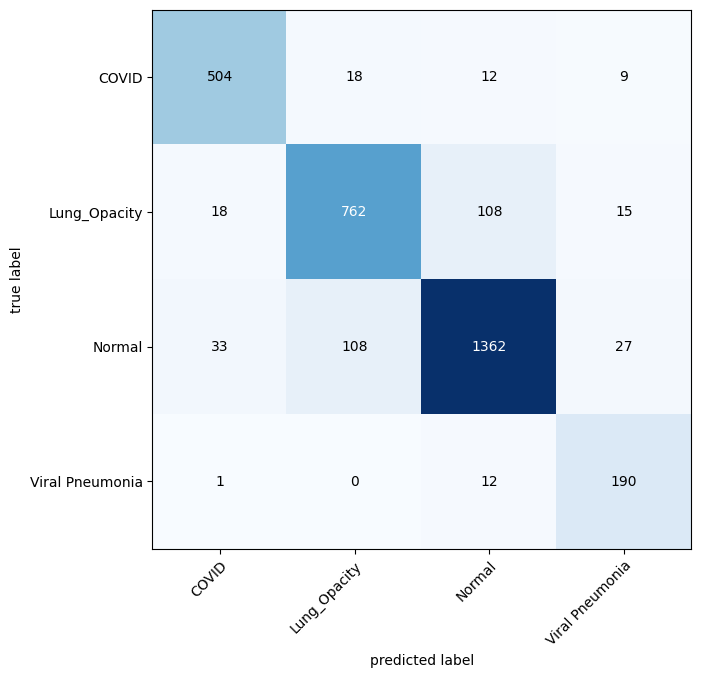

In [62]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion instance and compare predicitions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes = len(class_names))
confmat_tensor = confmat(y_pred_tensor,# predicitons
                         test_true # true labels
                         )

# 3. plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10, 7)
)